# Michelin Rated Restaurants in France - Processing

In [1]:
# Module import (comprehensive for entire notebook)
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import mapclassify
import folium
import branca

----
&nbsp;
## Import the French dataset

In [2]:
france = pd.read_csv("../../data/France/france_master_2025.csv")
france.head()

,name,address,city,country,price,cuisine,url,award,greenstar,stars,longitude,latitude
0,L'Ambroisie,"9 place des Vosges, Paris, 75004, France",Paris,France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,0,3.0,2.364521,48.855494
1,Flocons de Sel,"1775 route du Leutaz, Le Leutaz, Megève, 74120...",Megève,France,€€€€,Modern Cuisine,https://www.floconsdesel.com,3 Stars,0,3.0,6.596963,45.830240
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré, ...",Paris,France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,0,3.0,2.314598,48.871722
3,Arpège,"84 rue de Varenne, Paris, 75007, France",Paris,France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,1,3.0,2.317013,48.855754
4,Le Pré Catelan,"Route de Suresnes - bois de Boulogne, Paris, 7...",Paris,France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,0,3.0,2.250718,48.863937


In [3]:
# We change 'city' to 'location'
france.rename(columns={'city': 'location'}, inplace=True)

In [4]:
print(f"Shape of DataFrame: {france.shape}")
print(f"Unique Locations: {len(france['location'].unique())}")
print(f"Columns:\n{france.columns.unique().tolist()}")

Shape of DataFrame: (2985, 12)
Unique Locations: 1400
Columns:
['name', 'address', 'location', 'country', 'price', 'cuisine', 'url', 'award', 'greenstar', 'stars', 'longitude', 'latitude']


In [5]:
print(france.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985 entries, 0 to 2984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       2985 non-null   object 
 1   address    2985 non-null   object 
 2   location   2985 non-null   object 
 3   country    2985 non-null   object 
 4   price      2985 non-null   object 
 5   cuisine    2985 non-null   object 
 6   url        2831 non-null   object 
 7   award      2985 non-null   object 
 8   greenstar  2985 non-null   int64  
 9   stars      2985 non-null   float64
 10  longitude  2985 non-null   float64
 11  latitude   2985 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 280.0+ KB
None


----
&nbsp;
## Restaurant Locations Visualisation

<Axes: xlabel='longitude', ylabel='latitude'>

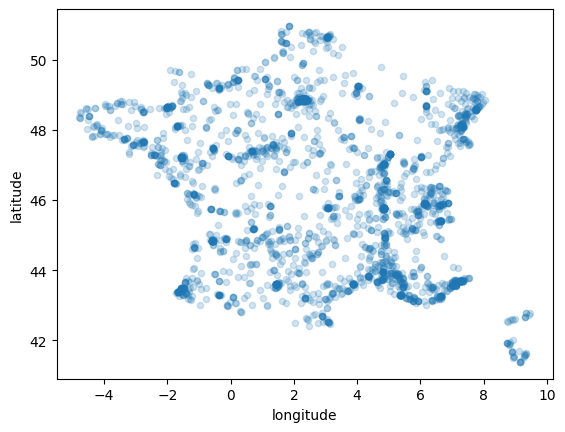

In [6]:
france.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2)

The datapoints trace the map of France quite well!

There are clusters in the Côte d'Azur, following the Rhone, the German border and in Paris

----
&nbsp;
## Partitioning the data regionally.

#### Creating new columns `department` & `region`

We import the `departments.csv` data which was created in `Data_preparation.ipynb`

In [7]:
departments = pd.read_csv("../../../../ExtraData/Demographics/departments.csv")
departments.head()

,department_num,department,capital,region
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes
1,02,Aisne,Laon,Hauts-de-France
2,03,Allier,Moulins,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur


We create a copy of `france_data` and extract the first two digits of code postal in `address`

In [8]:
france_data = france.copy()
france_data['department_num'] = france_data['address'].str.extract(r'(\b\d{5}\b)', expand=False).str[:2]

In [9]:
france_data = france_data.merge(departments, on='department_num', how='left')
print(france_data.columns.tolist())

['name', 'address', 'location', 'country', 'price', 'cuisine', 'url', 'award', 'greenstar', 'stars', 'longitude', 'latitude', 'department_num', 'department', 'capital', 'region']


In [10]:
france_data = france_data[['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'country',
                           'price', 'cuisine', 'url', 'award', 'stars', 'greenstar', 'longitude', 'latitude']]
france_data.head()

,name,address,location,department_num,department,capital,region,country,price,cuisine,url,award,stars,greenstar,longitude,latitude
0,L'Ambroisie,"9 place des Vosges, Paris, 75004, France",Paris,75,Paris,Paris,Île-de-France,France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494
1,Flocons de Sel,"1775 route du Leutaz, Le Leutaz, Megève, 74120...",Megève,74,Haute-Savoie,Annecy,Auvergne-Rhône-Alpes,France,€€€€,Modern Cuisine,https://www.floconsdesel.com,3 Stars,3.0,0,6.596963,45.830240
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré, ...",Paris,75,Paris,Paris,Île-de-France,France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722
3,Arpège,"84 rue de Varenne, Paris, 75007, France",Paris,75,Paris,Paris,Île-de-France,France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754
4,Le Pré Catelan,"Route de Suresnes - bois de Boulogne, Paris, 7...",Paris,75,Paris,Paris,Île-de-France,France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937


----
&nbsp;
### Amendments to the address and location formatting

In [11]:
# Check for addresses without a comma or with more than 3 commas (indicating more than 4 fields)
incorrect_format = france_data[~france_data['address'].str.count(',').isin([1, 2, 3])]

In [12]:
# Print out number addresses that don't match the expected format
if not incorrect_format.empty:
    print(f"Addresses with unexpected format: {len(incorrect_format['address'])}")

Addresses with unexpected format: 234


There exist a few addresses with multiple lines proceeding a standard form, "location", "postal code", "France"

In [13]:
def process_address(addr):
    # Split the address by commas and strip whitespace
    parts = [part.strip() for part in addr.split(',')]

    # If there are not enough parts, just return the original
    if len(parts) < 4:
        return addr, None, None

    # Extract the postal code and city
    postal_code = parts[-2]
    location = parts[-3]

    # Form the main address by joining the remaining parts (excluding postal code, city, and country)
    main_address = ', '.join(parts[:-3])

    return main_address, location, postal_code

In [14]:
# Apply the function to the DataFrame
addresses, locations, postal_codes = zip(*france_data['address'].apply(process_address))

france_data['address'] = addresses
france_data['location'] = [f"{location}, {postal_code}" for location, postal_code in zip(locations, postal_codes)]

In [15]:
france_data.head()

,name,address,location,department_num,department,capital,region,country,price,cuisine,url,award,stars,greenstar,longitude,latitude
0,L'Ambroisie,9 place des Vosges,"Paris, 75004",75,Paris,Paris,Île-de-France,France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494
1,Flocons de Sel,"1775 route du Leutaz, Le Leutaz","Megève, 74120",74,Haute-Savoie,Annecy,Auvergne-Rhône-Alpes,France,€€€€,Modern Cuisine,https://www.floconsdesel.com,3 Stars,3.0,0,6.596963,45.830240
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré","Paris, 75008",75,Paris,Paris,Île-de-France,France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722
3,Arpège,84 rue de Varenne,"Paris, 75007",75,Paris,Paris,Île-de-France,France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754
4,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",75,Paris,Paris,Île-de-France,France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937


In [16]:
# Check for the presence of commas in the 'address' column
contains_commas = france_data[france_data['address'].str.contains(',')]
print(f'Two-part addresses: {len(contains_commas)}')

Two-part addresses: 236


We've acquired 2 more restaurants with commas in the address

In [17]:
comma_addresses = france_data[france_data['address'].str.contains(',')]
address_parts = comma_addresses['address'].str.split(',').apply(len)
print(address_parts.value_counts())

address
2    218
3     18
Name: count, dtype: int64


In [18]:
three_part_addresses = comma_addresses[comma_addresses['address'].str.split(',').apply(len) == 3]
three_part_addresses[['address']]

,address
31,"Cheval Blanc, Le Jardin Alpin, Courchevel 1850"
56,"Le K2 Palace, 238 rue des Clarines, Courchevel..."
108,"Le Strato, Route de Bellecôte, Courchevel 1850"
156,"Alpaga, 66 allée des Marmoussets, route du Pra..."
216,"Annapurna, 734 route de l'Altiport, Courchevel..."
243,"Lieu dit Le Birol, 1204 route de Lacroix-Falga..."
272,"Hôtel du Golf, Les Ritons, 784 route du Clos-d..."
284,"Maison Bouvier - Les Suites, 39 rue du Val-Cla..."
405,"Lacave, 46200, France"
407,"Lacave, 46200, France"


In [19]:
# Access rows by index
rows_to_amend = france_data.loc[[405, 407]]
rows_to_amend

,name,address,location,department_num,department,capital,region,country,price,cuisine,url,award,stars,greenstar,longitude,latitude
405,Château de la Treyne,"Lacave, 46200, France","None, None",46,Lot,Cahors,Occitanie,France,€€€€,Classic Cuisine,https://www.chateaudelatreyne.com/fr/restauran...,1 Star,1.0,0,1.525388,44.849474
407,Le Pont de l'Ouysse,"Lacave, 46200, France","None, None",46,Lot,Cahors,Occitanie,France,€€€,"Modern Cuisine, Classic Cuisine",https://www.lepontdelouysse.com/,1 Star,1.0,0,1.550233,44.844231


We search for an address manually using the url. *Lacave* is a small village in the Dordogne. The address is simply the Hotel name, commune, postal code

In [20]:
france_data.at[405, 'address'] = 'Lacave, 46200'
france_data.at[407, 'address'] = 'Lacave, 46200'

france_data.at[405, 'location'] = 'Lacave, 46200'
france_data.at[407, 'location'] = 'Lacave, 46200'

We now create 2 more dataframes; `paris` and `rest_of_france`

In [21]:
paris = france_data[france_data['department'] == 'Paris']
rest_of_france = france_data[france_data['department'] != 'Paris']

In [22]:
paris.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, 0 to 2984
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            460 non-null    object 
 1   address         460 non-null    object 
 2   location        460 non-null    object 
 3   department_num  460 non-null    object 
 4   department      460 non-null    object 
 5   capital         460 non-null    object 
 6   region          460 non-null    object 
 7   country         460 non-null    object 
 8   price           460 non-null    object 
 9   cuisine         460 non-null    object 
 10  url             441 non-null    object 
 11  award           460 non-null    object 
 12  stars           460 non-null    float64
 13  greenstar       460 non-null    int64  
 14  longitude       460 non-null    float64
 15  latitude        460 non-null    float64
dtypes: float64(3), int64(1), object(12)
memory usage: 61.1+ KB


#### Only `url` has missing values

In [23]:
rest_of_france.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2525 entries, 1 to 2983
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            2525 non-null   object 
 1   address         2525 non-null   object 
 2   location        2525 non-null   object 
 3   department_num  2525 non-null   object 
 4   department      2482 non-null   object 
 5   capital         2482 non-null   object 
 6   region          2482 non-null   object 
 7   country         2525 non-null   object 
 8   price           2525 non-null   object 
 9   cuisine         2525 non-null   object 
 10  url             2390 non-null   object 
 11  award           2525 non-null   object 
 12  stars           2525 non-null   float64
 13  greenstar       2525 non-null   int64  
 14  longitude       2525 non-null   float64
 15  latitude        2525 non-null   float64
dtypes: float64(3), int64(1), object(12)
memory usage: 335.4+ KB


#### `rest_of_france` has some null values for `department`, `capital` and `region`

In [24]:
# Select rows where 'department' and 'region' are NaN
rest_of_france_null = france_data[(france_data['department'].isnull()) & (france_data['region'].isnull())]
rest_of_france_null

,name,address,location,department_num,department,capital,region,country,price,cuisine,url,award,stars,greenstar,longitude,latitude
109,Casadelmar,Route de Palombaggia,"Porto-Vecchio, 20137",20,NaN,NaN,NaN,France,€€€€,Modern Cuisine,https://www.casadelmar.fr,2 Stars,2.00,0,9.309977,41.594810
150,Le Charlie,Bella Vista Hôtel,"Porticcio, 20166",20,NaN,NaN,NaN,France,€€€€,Modern Cuisine,https://www.lapiscineporticcio.com/the-restaurant,1 Star,1.00,0,8.810522,41.895070
244,Finestra by Italo Bassi,51 quai Jérôme-Comparetti,"Bonifacio, 20169",20,NaN,NaN,NaN,France,€€€€,"Italian, Mediterranean Cuisine",https://finestra-d-amore.fr/,1 Star,1.00,0,9.163711,41.387955
591,A Casa di Mà,Route de Calvi,"Lumio, 20260",20,NaN,NaN,NaN,France,€€€€,Modern Cuisine,https://www.acasadima.com/,1 Star,1.00,0,8.831886,42.581304
623,La Verrière,"Hôtel Marinca, lieu-dit Vitricella","Olmeto, 20113",20,NaN,NaN,NaN,France,€€€€,Modern Cuisine,https://www.hotel-marinca.com/,1 Star,1.00,0,8.902694,41.691352
640,La Table de la Ferme,"Domaine de Murtoli, Vallée de l'Ortolo","Sartène, 20100",20,NaN,NaN,NaN,France,€€€€,"Modern Cuisine, Corsican",https://www.murtoli.com/,1 Star,1.00,0,8.946903,41.522976
733,U Licettu,Plaine de Cuttoli,"Cuttoli, 20167",20,NaN,NaN,NaN,France,€€,Traditional Cuisine,https://www.u-licettu.com/,Bib Gourmand,0.50,0,8.845830,41.963936
780,L'Aghjalle,Toro Soprano,"Santa-Reparata-di-Balagna, 20220",20,NaN,NaN,NaN,France,€€,Corsican,http://www.laghjalle.com,Bib Gourmand,0.50,0,8.921134,42.586521
821,A Mandria di Pigna,Village,"Pigna, 20220",20,NaN,NaN,NaN,France,€€,Corsican,https://www.restaurantpigna.com/,Bib Gourmand,0.50,0,8.903190,42.598780
1084,Santu Pultru,D48,"Sartène, 20100",20,NaN,NaN,NaN,France,€€,Traditional Cuisine,http://www.randochevalcorse.fr,Selected Restaurants,0.25,0,8.913810,41.567180


There's some NBSP characters present. We can remove them from all data

In [25]:
def strip_nbsp(cell):
    if isinstance(cell, str):
        return cell.replace('\xa0', '')
    return cell

In [26]:
france_data = france_data.map(strip_nbsp)

In [27]:
contains_nbsp = (france_data.map(lambda cell: r'\xa0' in str(cell))).any().any()
print(f"NBSP present? {contains_nbsp}")

NBSP present? False


`department_num`: 20 represents Corsica

There are two departments for Corse; 2A and 2B

In [28]:
def extract_postal_code(location):
    if isinstance(location, str) and ',' in location:
        parts = location.split(',')
        return parts[-1].strip()
    return ""

def map_corsica_department_info(code_postal):
    code_postal = str(code_postal)

    if code_postal.startswith(('200', '201')):
        return ('2A', 'Corse-du-Sud', 'Ajaccio', 'Corsica')
    elif code_postal.startswith('202'):
        return ('2B', 'Haute-Corse', 'Bastia', 'Corsica')
    return (None, None, None, None)

In [29]:
# Create boolean mask
mask_corsica = france_data['department_num'] == "20"
# Extract postal codes from location
postal_codes = france_data.loc[mask_corsica, 'location'].apply(extract_postal_code)

# Apply the mapping
corsica_info = postal_codes.apply(lambda cp: pd.Series(map_corsica_department_info(cp)))
corsica_info.columns = ['department_num', 'department', 'capital', 'region']

# Assign the mapped values back to the DataFrame
france_data.loc[mask_corsica, ['department_num', 'department', 'capital', 'region']] = corsica_info

# Verify the changes
france_data[france_data['department_num'] == '20'][['department_num', 'department']]

,department_num,department


In [30]:
# We drop the column 'country' as only France represented
france_data.drop('country', axis=1, inplace=True)

In [31]:
# We split by city != Paris again
rest_of_france = france_data[france_data['department'] != 'Paris']

In [32]:
rest_of_france.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2525 entries, 1 to 2983
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            2525 non-null   object 
 1   address         2525 non-null   object 
 2   location        2525 non-null   object 
 3   department_num  2525 non-null   object 
 4   department      2525 non-null   object 
 5   capital         2525 non-null   object 
 6   region          2525 non-null   object 
 7   price           2525 non-null   object 
 8   cuisine         2525 non-null   object 
 9   url             2390 non-null   object 
 10  award           2525 non-null   object 
 11  stars           2525 non-null   float64
 12  greenstar       2525 non-null   int64  
 13  longitude       2525 non-null   float64
 14  latitude        2525 non-null   float64
dtypes: float64(3), int64(1), object(11)
memory usage: 315.6+ KB


Again, `url` has some missing values.

We export `france_data` as `all_restaurants.csv`

In [33]:
# Export the DataFrame to a .csv file
france_data.to_csv('../../data/France/all_restaurants.csv', index=False)

----
&nbsp;
## Merging `demographics` and `departemments.geojson` for EDA

In [34]:
demographics = pd.read_csv("../../../../ExtraData/Demographics/demographics_2023.csv")
demographics.head()

,department_num,department,capital,region,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km)
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,16726.40,24916.84,10.8,5.5,15.96,671289.0,115.1,5832.22
1,02,Aisne,Laon,Hauts-de-France,12016.40,22864.08,18.8,10.5,14.46,525558.0,71.7,7329.96
2,03,Allier,Moulins,Auvergne-Rhône-Alpes,8278.98,24734.42,16.2,7.8,14.19,334715.0,45.6,7340.24
3,04,Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur,4154.79,24852.34,17.1,8.1,14.60,167179.0,24.0,6965.79
4,05,Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur,3756.22,26512.56,14.7,6.6,13.99,141677.0,25.4,5577.83


To visualise the demographics data, we require a GeoJSON file of the departmental boundaries of metropolitan France

Credit: [gregoiredavid.github](https://github.com/gregoiredavid/france-geojson)

In [35]:
# Load the GeoJSON file
gdf = gpd.read_file('../../../../ExtraData/Geodata/departements.geojson')
gdf.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


We can join the geoJSON data on `code` and delete the `nom` column

In [36]:
# Merge dataframes
merged = gdf.set_index('code').join(demographics.set_index('department_num'))

# Delete 'nom' column in place
merged.drop(columns='nom', inplace=True)

print(len(merged))
merged.head()

96


,geometry,department,capital,region,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km)
code,,,,,,,,,,,,
01,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,16726.40,24916.84,10.8,5.5,15.96,671289.0,115.1,5832.22
02,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",Aisne,Laon,Hauts-de-France,12016.40,22864.08,18.8,10.5,14.46,525558.0,71.7,7329.96
03,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3...",Allier,Moulins,Auvergne-Rhône-Alpes,8278.98,24734.42,16.2,7.8,14.19,334715.0,45.6,7340.24
04,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur,4154.79,24852.34,17.1,8.1,14.60,167179.0,24.0,6965.79
05,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur,3756.22,26512.56,14.7,6.6,13.99,141677.0,25.4,5577.83


### Creating Visualisation of `population` & `population_density`

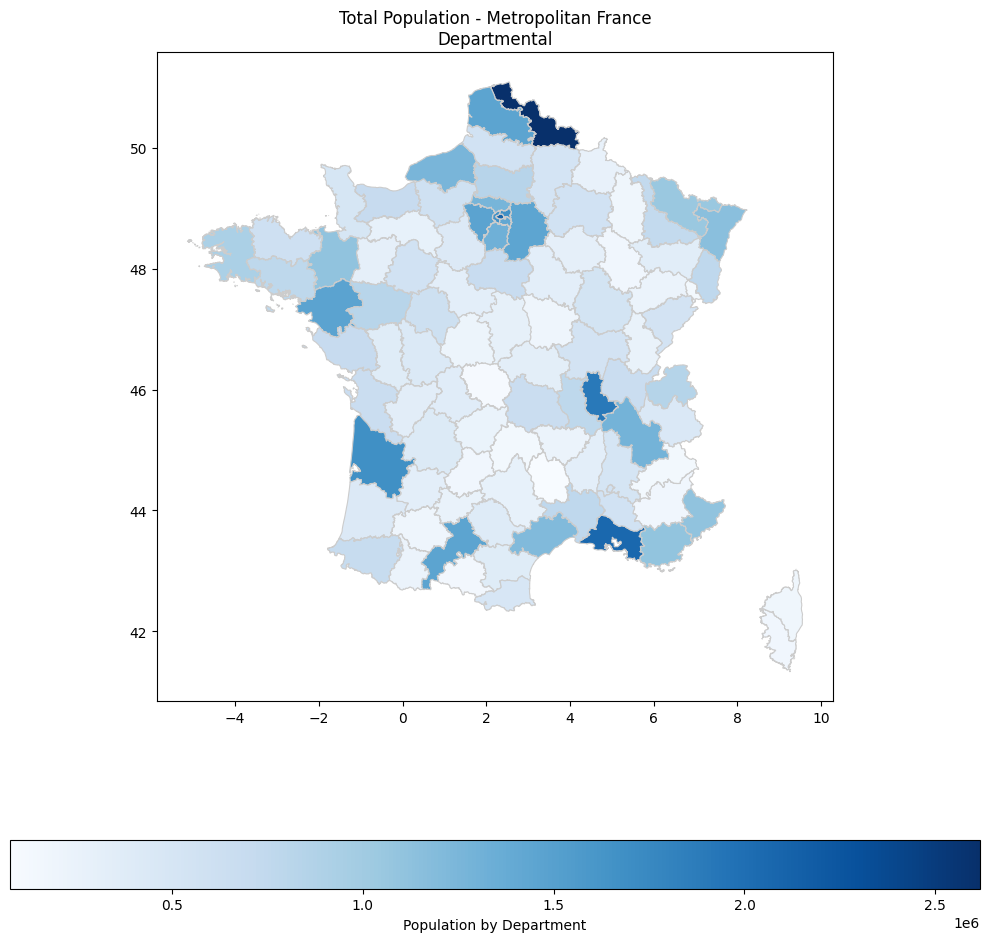

In [37]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create map
merged.plot(column='municipal_population',
            cmap='Blues',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=True,
            legend_kwds={'label': "Population by Department",
                         'orientation': "horizontal"})
plt.title("Total Population - Metropolitan France\nDepartmental")
plt.tight_layout()
plt.show()

#### There's a huge range of values in `population_density`

We apply a log transformation and bin by 'natural breaks' in the data

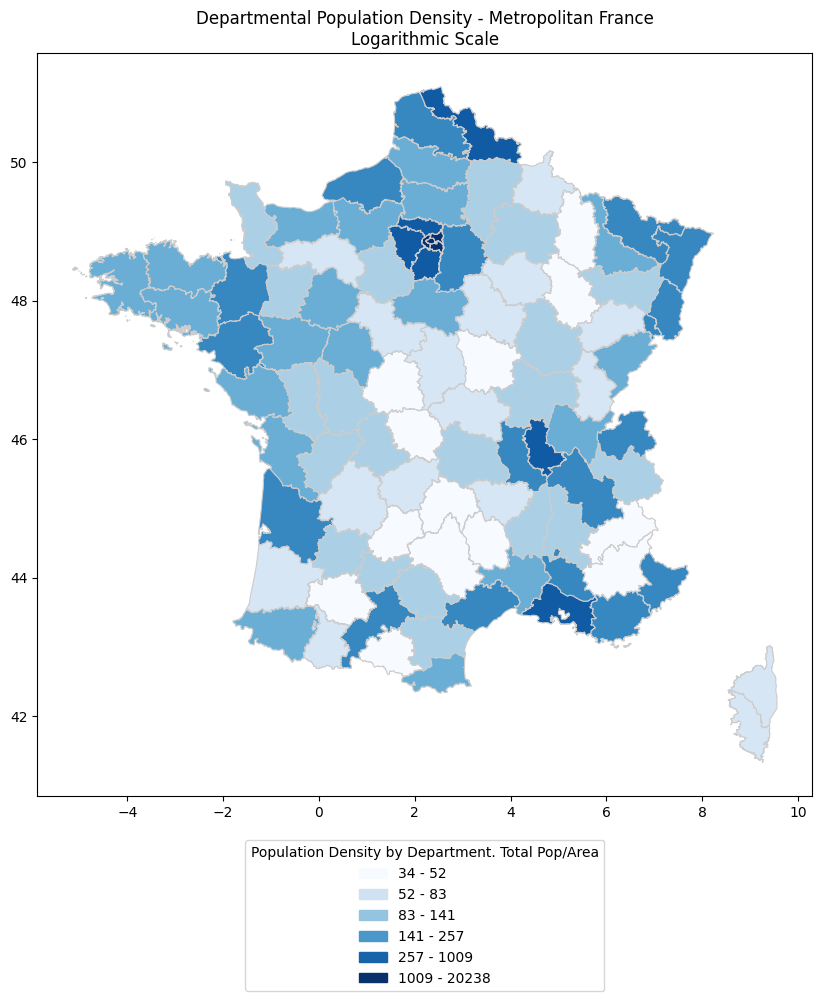

In [38]:
# Apply log transformation to the density column
merged['log_population_density'] = np.log(merged['population_density(inhabitants/sq_km)'] + 1)  # Add 1 or a small constant to avoid log(0)
# Define classification scheme
classifier = mapclassify.NaturalBreaks(merged['log_population_density'], k=7)  # Using NaturalBreaks
# Apply classification to dataframe
merged['classification'] = merged[['log_population_density']].apply(classifier)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create map
merged.plot(column='classification',
            cmap='Blues',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=False) # we will create a custom legend

# Create legend
labels = []
# Create a list of bin boundaries in original scale
bin_edges_exp = np.exp(classifier.bins) - 1
for i in range(len(bin_edges_exp) - 1):
    label = f"{bin_edges_exp[i]:.0f} - {bin_edges_exp[i+1]:.0f}"
    labels.append(mpatches.Patch(color=plt.cm.Blues(i / (len(bin_edges_exp) - 2)),
                                 label=label))
plt.legend(handles=labels,
           title='Population Density by Department. Total Pop/Area',
           bbox_to_anchor=(0.5, -0.05),
           loc='upper center')
plt.title("Departmental Population Density - Metropolitan France\nLogarithmic Scale")
plt.show()

----
&nbsp;
## Grouping restaurants by `department` and `region` based on the number of Michelin stars.

In [39]:
# We create a copy
france_data_copy = france_data.copy()

# Create dummy variables for each category of 'star'
france_data_copy['green_stars'] = france_data_copy['greenstar'].apply(lambda x: 1 if x == 1 else 0)
france_data_copy['selected'] = france_data_copy['stars'].apply(lambda x: 1 if x == 0.25 else 0)
france_data_copy['bib_gourmand'] = france_data_copy['stars'].apply(lambda x: 1 if x == 0.5 else 0)
france_data_copy['1_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 1.0 else 0)
france_data_copy['2_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 2.0 else 0)
france_data_copy['3_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 3.0 else 0)

#### By `region`
We sort `france_data` by total number of awarded restaurants

In [40]:
# Group by 'region' and sum 'bib', '1_star', '2_star' and '3_star'
region_grouped = france_data_copy.groupby('region')[['green_stars', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star']].sum()

# Create a copy for plotting
region_grouped_two = region_grouped.copy()

`region_grouped` is created to be merged with the demographics data

In [41]:
# Create a 'total_ star' column - sum of stars
# Individual stars are summed here. ie, If 2 star then stars = 2
region_grouped['total_stars'] = region_grouped['1_star']*1 + region_grouped['2_star']*2 + region_grouped['3_star']*3
# Create a 'total' column = sum of restaurants
region_grouped['starred_restaurants'] =  region_grouped['1_star'] + region_grouped['2_star'] + region_grouped['3_star']

# Sort the dataframe by the 'total_stars' column in descending order
region_grouped.sort_values('total_stars', ascending=True, inplace=True)

----
&nbsp;
### Plotting starred restaurants by `region`

We use `region_grouped_two` for plotting whilst excluding Île-de-France

In [42]:
# Create a 'total_starred' column - sum of starred restaurants
region_grouped_two['total_starred'] = region_grouped_two['1_star'] + region_grouped_two['2_star'] + region_grouped_two['3_star']

# Sort the dataframes by the 'total' and 'total_stars' columns in descending order
region_grouped_two.sort_values('total_starred', ascending=True, inplace=True)

In [43]:
# Exclude 'Île-de-France'
region_grouped_excl_paris = region_grouped_two[region_grouped_two.index.get_level_values('region') != 'Île-de-France']

In [44]:
# Drop the 'bib_gourmand' and 'total_starred' columns
region_grouped_excl_paris = region_grouped_excl_paris.copy()
region_grouped_excl_paris.drop(['green_stars', 'selected', 'bib_gourmand', 'total_starred'], axis=1, inplace=True)

Plot the data

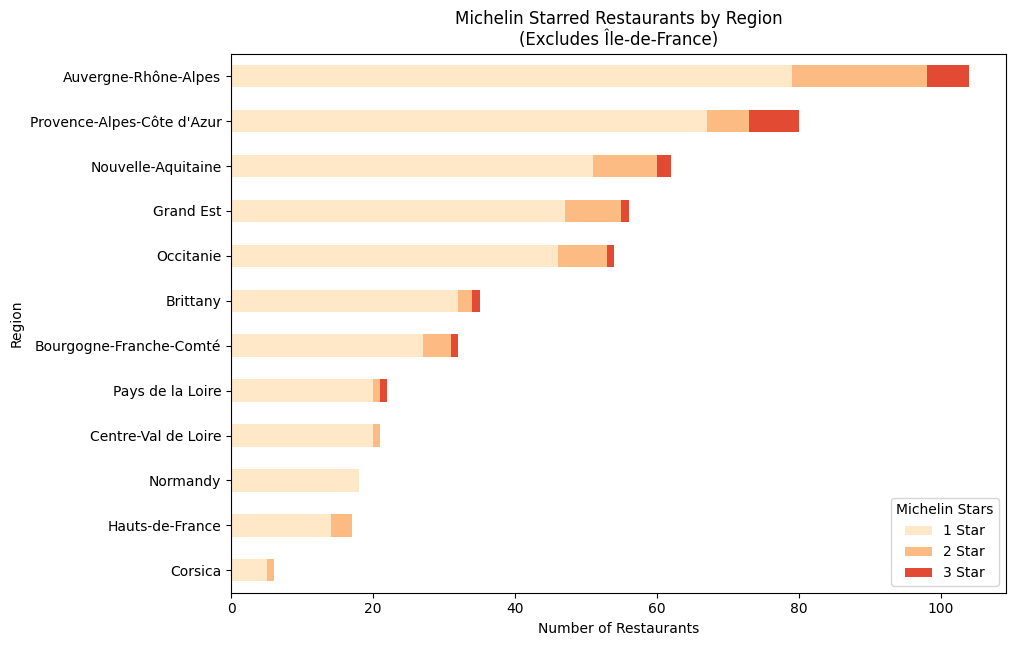

In [45]:
# Create a horizontal stacked bar plot
region_grouped_excl_paris.plot(kind='barh', stacked=True, figsize=(10, 7),
                    color=['#fee8c8','#fdbb84','#e34a33'])

# Add title and labels
plt.title('Michelin Starred Restaurants by Region\n(Excludes Île-de-France)')
plt.ylabel('Region')
plt.xlabel('Number of Restaurants')

# Add a legend
plt.legend(title='Michelin Stars', labels=['1 Star', '2 Star', '3 Star'])

# Show the plot
plt.show()

----
&nbsp;
### By `department`

We sort `france_data` by total number of awarded restaurants

In [46]:
# Group by 'department' and sum 'bibs', '1_star', '2_star' and '3_star'
dept_grouped = france_data_copy.groupby(['department_num', 'department'])[['green_stars', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star']].sum()

# Creating a copy for plotting
dept_grouped_two = dept_grouped.copy()

`dept_grouped` is created to be merged with the demographics data

In [47]:
# Create a 'total_ stars' column - sum of stars
# Individual stars are summed here. ie, If 2 star then stars = 2
dept_grouped['total_stars'] = dept_grouped['1_star']*1 + dept_grouped['2_star']*2 + dept_grouped['3_star']*3

# Create a 'starred_restaurants' column = sum of starred restaurants
dept_grouped['starred_restaurants'] =  dept_grouped['1_star'] + dept_grouped['2_star'] + dept_grouped['3_star']

# Sort the dataframe by the 'department_num' column in descending order
dept_grouped.sort_values('department_num', ascending=True, inplace=True)

Two new statistics have been created;
- `total_stars`: sum of **individual** stars
- `total_restaurants`

In [48]:
dept_grouped.tail()

,,green_stars,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
department_num,department,,,,,,,,
91,Essonne,1,4,1,0,0,0,0,0
92,Hauts-de-Seine,0,19,3,4,0,0,4,4
93,Seine-Saint-Denis,0,3,0,1,0,0,1,1
94,Val-de-Marne,0,4,0,1,0,0,1,1
95,Val-d'Oise,1,3,0,1,0,0,1,1


----
&nbsp;
### Plotting starred restaurants by `department`
Using `dept_grouped_two`, we group and plot the top 10 departments by total stars. A subtly different statistic is created;
- `total_starred`: sum of restaurants with stars as opposed to sum of stars

In [49]:
# Create a 'total_starred' column
dept_grouped_two['total_starred'] = dept_grouped_two['1_star'] + dept_grouped['2_star'] + dept_grouped['3_star']

# Sort the dataframe by the 'department_num' column in descending order
dept_grouped_two.sort_values('department_num', ascending=True, inplace=True)

In [50]:
# Exclude 'Paris'
dept_grouped_no_paris = dept_grouped_two[dept_grouped_two.index.get_level_values('department').str.strip() != 'Paris']

In [51]:
# Sort by 'total_starred' in descending order and keep the top 10
dept_grouped_top10 = dept_grouped_no_paris.sort_values('total_starred', ascending=False).head(10)

# Drop the 'bib_gourmand' & 'total' columns
dept_grouped_top10 = dept_grouped_top10.drop(columns=['green_stars', 'selected', 'bib_gourmand', 'total_starred'])

# Reverse the order of the DataFrame
dept_grouped_top10 = dept_grouped_top10.iloc[::-1]

Plot the data

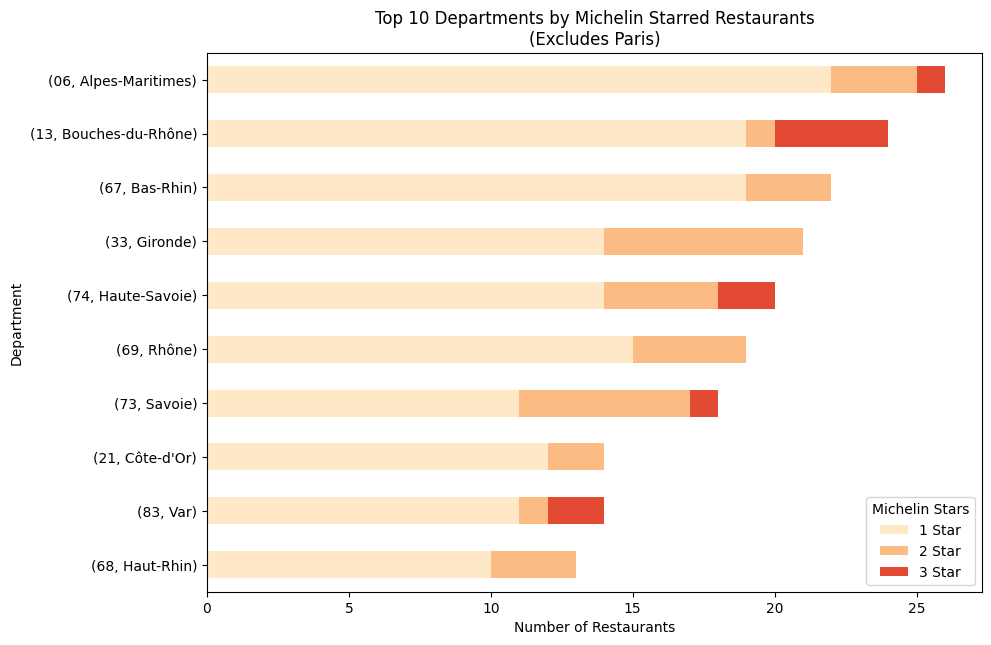

In [52]:
# Plot the data
dept_grouped_top10.plot(kind='barh', stacked=True, figsize=(10, 7),
                        color=['#fee8c8','#fdbb84','#e34a33'])

# Add title and labels
plt.title('Top 10 Departments by Michelin Starred Restaurants\n(Excludes Paris)')
plt.ylabel('Department')
plt.xlabel('Number of Restaurants')

# Add a legend
plt.legend(title='Michelin Stars', labels=['1 Star', '2 Star', '3 Star'])

# Show the plot
plt.show()

----
&nbsp;
## Merging Michelin stars by `department` & `region` with the population demographics data

### Merging `dept_grouped` with `demographics`

In [53]:
print(f"Rows in `demographics`: {len(demographics)}")

# We index the multi-indexed df
dept_grouped.reset_index(inplace=True)
print(f"Rows in `dept_grouped`: {len(dept_grouped)}")

Rows in `demographics`: 96
Rows in `dept_grouped`: 96


There are some discrepancies. We create sets of unique `departments` for both DataFrames

In [54]:
set1 = set(dept_grouped['department'].unique())
set2 = set(demographics['department'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? True


In [55]:
# Create a copy of demographics as we will also use 'demographics' for the regional dataframe
demographics_copy = demographics.copy()

In [56]:
# Sort dataframes on 'department_num'
dept_grouped = dept_grouped.sort_values('department_num')
demographics = demographics.sort_values('department_num')

In [57]:
# Merge demographics data with department data
departmental_data = dept_grouped.merge(demographics, how='inner', on='department_num')

In [58]:
print(departmental_data.columns.tolist())

['department_num', 'department_x', 'green_stars', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'department_y', 'capital', 'region', 'GDP_millions(€)', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)', 'area(sq_km)']


In [59]:
# Drop 'department_y' column
departmental_data = departmental_data.drop('department_y', axis=1)

# Rename 'department_x' to 'department'
departmental_data = departmental_data.rename(columns={'department_x': 'department'})

# Order columns
departmental_data = departmental_data[['department_num', 'department', 'capital', 'region', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star',
                                       'total_stars', 'starred_restaurants', 'green_stars', 'GDP_millions(€)', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)',
                                       'area(sq_km)']]

In [60]:
departmental_data.head(3)

,department_num,department,capital,region,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,green_stars,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km)
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,16,7,4,1,0,6,5,1,16726.40,24916.84,10.8,5.5,15.96,671289.0,115.1,5832.22
1,02,Aisne,Laon,Hauts-de-France,3,0,2,0,0,2,2,0,12016.40,22864.08,18.8,10.5,14.46,525558.0,71.7,7329.96
2,03,Allier,Moulins,Auvergne-Rhône-Alpes,8,4,2,0,0,2,2,0,8278.98,24734.42,16.2,7.8,14.19,334715.0,45.6,7340.24


In [61]:
departmental_data.shape

(96, 20)

----
&nbsp;
### Merging `region_grouped` with `demographics`

Summation of the numerical statistics by region in `demographics`

In [62]:
# Group the demographics data by 'region' and sum 'municipal_population' and 'area(sq_km)'
# First, we'll sum up the straightforward columns:
grouped_demographics = demographics_copy.groupby('region')[['municipal_population', 'area(sq_km)']].sum()

# Summing up the GDP for each region:
grouped_demographics['GDP_millions(€)'] = demographics_copy.groupby('region')['GDP_millions(€)'].sum().values

# Calculating GDP per capita for each region:
grouped_demographics['GDP_per_capita(€)'] = grouped_demographics['GDP_millions(€)'] * 1e6 / grouped_demographics['municipal_population']

# Calculate population density:
grouped_demographics['population_density(inhabitants/sq_km)'] = round(grouped_demographics['municipal_population'] /
                                                                      grouped_demographics['area(sq_km)'], 2)
# Computing weighted averages:
for col in ['poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)']:
    # Multiply the column by population to weight it
    demographics_copy[col + '_weighted'] = demographics_copy[col] * demographics_copy['municipal_population']
    # Group by region and sum the weighted values
    sum_weighted = demographics_copy.groupby('region')[col + '_weighted'].sum()
    # Divide by summed population to get the average for the region
    grouped_demographics[col] = sum_weighted / grouped_demographics['municipal_population']

grouped_demographics.reset_index(inplace=True)

In [63]:
# Merge demographics data with department data
regional_data = region_grouped.merge(grouped_demographics, how='inner', on='region')

# Change order to match departmental data
new_order = ['region', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'green_stars', 'GDP_millions(€)', 'GDP_per_capita(€)', 'poverty_rate(%)', 'average_annual_unemployment_rate(%)', 'average_net_hourly_wage(€)', 'municipal_population', 'population_density(inhabitants/sq_km)', 'area(sq_km)']
regional_data = regional_data[new_order]

In [64]:
regional_data.head(3)

,region,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,green_stars,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km)
0,Corsica,34,3,5,1,0,7,6,0,9083.98,25859.950580,18.120160,6.421847,14.579434,351276.0,40.07,8767.33
1,Normandy,63,25,18,0,0,18,18,4,92016.51,27557.493485,13.767851,6.866149,15.379456,3339074.0,111.52,29941.26
2,Hauts-de-France,67,9,14,3,0,20,17,5,163006.00,27172.575845,18.033954,9.021599,15.402444,5998916.0,188.73,31785.23


There's a slight discrepancy in the calculated GDP data for 2021 on [INSEE](https://statistiques-locales.insee.fr/#view=map1&c=indicator)

----
&nbsp;
## Adding the coordinates of individual restaurants.

In [65]:
print(france_data.columns.tolist())

['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'greenstar', 'longitude', 'latitude']


To enrich the dataset, we attach the precise (latitude, longitude) coordinates of specific starred restaurants to both `regional_data` and `departmental_data`.

This will be in the form  of a dictionary:
```python
{
  '1_star': [(lat1, long1), (lat2, long2), ..., (latN, longN)],
  '2_star': [(lat1, long1), (lat2, long2), ..., (latN, longN)],
  '3_star': [(lat1, long1), (lat2, long2), ..., (latN, longN)],
}
```

This structure will enable us to record specific locations of Michelin-starred restaurants while maintaining a compact representation of the data.

### Regional

In [66]:
# Create a separate DataFrame with star ratings, regions, and coordinates
location_data_region = france_data[['stars', 'region', 'latitude', 'longitude']]

# Convert to a dictionary where keys are tuples of star rating and region
location_dict_region = (
    location_data_region
    .groupby(['stars', 'region'])[['latitude', 'longitude']]
    .apply(lambda df: list(zip(df.latitude, df.longitude)))
    .to_dict()
)

In [67]:
# Create a mapping from star values to string labels
star_label_mapping = {
    0.25: 'Selected',
    0.5: 'Bib',
    1: '1',
    2: '2',
    3: '3'
}

In [68]:
# Create a function to map these dictionaries to original DataFrame
def map_locations_region(row):
    return {star_label_mapping[stars]: location_dict_region.get((stars, row['region'])) for stars in [0.25, 0.5, 1, 2, 3]}

In [69]:
# Apply this function to create a new 'locations' column
regional_data['locations'] = regional_data.apply(map_locations_region, axis=1)

### Departmental

In [70]:
# Create a separate DataFrame with star ratings, department, and coordinates
location_data_department = france_data[['stars', 'department_num', 'latitude', 'longitude']]

# Convert to a dictionary where keys are tuples of star rating and department
location_dict_department = (
    location_data_department
    .groupby(['stars', 'department_num'])[['latitude', 'longitude']]
    .apply(lambda df: list(zip(df.latitude, df.longitude)))
    .to_dict()
)

In [71]:
# Create a function to map these dictionaries to original DataFrame for departments
def map_locations_department(row):
    return {star_label_mapping[stars]: location_dict_department.get((stars, row['department_num'])) for stars in [0.25, 0.5, 1, 2, 3]}

In [72]:
# Apply this function to create a new 'locations' column
departmental_data['locations'] = departmental_data.apply(map_locations_department, axis=1)

----
&nbsp;
## Merging with the GeoJSON data

We merge `departmental_data` with `departements.geojson`

In [73]:
gdf_dept = gpd.read_file('../../../../ExtraData/Geodata/departements.geojson')
gdf_dept.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


We will merge on `code` and check the two sets of departmental codes are equal

In [74]:
set1 = set(departmental_data['department_num'].unique())
set2 = set(gdf_dept['code'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? True


In [75]:
# Merge dataframes
dept_rest_demo = gdf.set_index('code').join(departmental_data.set_index('department_num'))

# Reset index to keep 'department_num' as a column
dept_rest_demo.reset_index(inplace=True)

# Delete 'nom' column in place
dept_rest_demo.drop(columns='nom', inplace=True)

print(len(dept_rest_demo))
dept_rest_demo.head()

96


,code,geometry,department,capital,region,selected,bib_gourmand,1_star,2_star,3_star,...,green_stars,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km),locations
0,01,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,16,7,4,1,0,...,1,16726.40,24916.84,10.8,5.5,15.96,671289.0,115.1,5832.22,"{'Selected': [(45.7358533, 5.7079944), (46.305..."
1,02,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",Aisne,Laon,Hauts-de-France,3,0,2,0,0,...,0,12016.40,22864.08,18.8,10.5,14.46,525558.0,71.7,7329.96,"{'Selected': [(49.5694557, 3.6221072), (49.615..."
2,03,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3...",Allier,Moulins,Auvergne-Rhône-Alpes,8,4,2,0,0,...,0,8278.98,24734.42,16.2,7.8,14.19,334715.0,45.6,7340.24,"{'Selected': [(46.54767, 2.980203), (46.323322..."
3,04,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur,8,0,4,0,0,...,1,4154.79,24852.34,17.1,8.1,14.60,167179.0,24.0,6965.79,"{'Selected': [(43.8307812, 5.7979837), (44.093..."
4,05,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur,4,2,0,0,0,...,0,3756.22,26512.56,14.7,6.6,13.99,141677.0,25.4,5577.83,"{'Selected': [(44.9651429, 6.5288612), (44.976..."


In [76]:
print(dept_rest_demo.dtypes)

code                                       object
geometry                                 geometry
department                                 object
capital                                    object
region                                     object
selected                                    int64
bib_gourmand                                int64
1_star                                      int64
2_star                                      int64
3_star                                      int64
total_stars                                 int64
starred_restaurants                         int64
green_stars                                 int64
GDP_millions(€)                           float64
GDP_per_capita(€)                         float64
poverty_rate(%)                           float64
average_annual_unemployment_rate(%)       float64
average_net_hourly_wage(€)                float64
municipal_population                      float64
population_density(inhabitants/sq_km)     float64


----
&nbsp;
We merge `regional_data` with the GeoJSON data; `regions.geojson`

In [77]:
gdf_region = gpd.read_file('../../../../ExtraData/Geodata/regions.geojson')
gdf_region.head()

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ..."
1,24,Centre-Val de Loire,"POLYGON ((2.87463 47.52042, 2.88845 47.50943, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ..."
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.07822 49.38849..."
4,32,Hauts-de-France,"POLYGON ((4.04797 49.40564, 4.03991 49.3974, 4..."


In [78]:
set1 = set(regional_data['region'].unique())
set2 = set(gdf_region['nom'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? False


In [79]:
print("In set1 but not in set2: ", set1 - set2)
print("In set2 but not in set1: ", set2 - set1)

In set1 but not in set2:  {'Normandy', 'Brittany', 'Corsica'}
In set2 but not in set1:  {'Normandie', 'Corse', 'Bretagne'}


In [80]:
# Define a dictionary to map English region names to French
region_translation = {'Brittany': 'Bretagne', 'Corsica': 'Corse', 'Normandy': 'Normandie'}

# Use replace to update the 'region' column
regional_data['region'] = regional_data['region'].replace(region_translation)

We also update `region` in `dept_rest_demo`

In [81]:
dept_rest_demo['region'] = dept_rest_demo['region'].replace(region_translation)

In [82]:
set1 = set(regional_data['region'].unique())
set2 = set(dept_rest_demo['region'].unique())
set3 = set(gdf_region['nom'].unique())
print(f"Sets equal? {set1 == set2 == set3}")

Sets equal? True


In [83]:
# Merge the dataframes on 'nom' and 'region'
region_rest_demo = gdf_region.merge(regional_data, left_on='nom', right_on='region')

In [84]:
# Delete 'nom' column in place
region_rest_demo.drop(columns=['code', 'nom'], inplace=True)

In [85]:
region_rest_demo.head()

,geometry,region,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,green_stars,GDP_millions(€),GDP_per_capita(€),poverty_rate(%),average_annual_unemployment_rate(%),average_net_hourly_wage(€),municipal_population,population_density(inhabitants/sq_km),area(sq_km),locations
0,"POLYGON ((2.59052 49.07965, 2.63327 49.10838, ...",Île-de-France,359,39,112,17,10,176,139,11,700754.40,56599.340730,16.148741,7.023389,21.275977,12380964.0,1021.03,12125.93,"{'Selected': [(48.8620352, 2.3510841), (48.879..."
1,"POLYGON ((2.87463 47.52042, 2.88845 47.50943, ...",Centre-Val de Loire,79,17,20,1,0,22,21,5,72707.28,28163.683178,13.465104,6.831572,15.411722,2581597.0,65.79,39238.50,"{'Selected': [(46.8114663, 1.6908734), (46.810..."
2,"POLYGON ((3.62942 46.74946, 3.57569 46.74952, ...",Bourgogne-Franche-Comté,115,21,27,4,1,38,32,6,76921.54,27433.013894,13.402493,6.416168,14.928133,2803977.0,58.64,47820.55,"{'Selected': [(47.2387368, 4.9677757), (47.322..."
3,"POLYGON ((-1.11962 49.35557, -1.07822 49.38849...",Normandie,63,25,18,0,0,18,18,4,92016.51,27557.493485,13.767851,6.866149,15.379456,3339074.0,111.52,29941.26,"{'Selected': [(48.4787062, 0.5596934), (49.528..."
4,"POLYGON ((4.04797 49.40564, 4.03991 49.3974, 4...",Hauts-de-France,67,9,14,3,0,20,17,5,163006.00,27172.575845,18.033954,9.021599,15.402444,5998916.0,188.73,31785.23,"{'Selected': [(50.6864947, 2.8836507), (50.643..."


In [86]:
print(region_rest_demo.dtypes)

geometry                                 geometry
region                                     object
selected                                    int64
bib_gourmand                                int64
1_star                                      int64
2_star                                      int64
3_star                                      int64
total_stars                                 int64
starred_restaurants                         int64
green_stars                                 int64
GDP_millions(€)                           float64
GDP_per_capita(€)                         float64
poverty_rate(%)                           float64
average_annual_unemployment_rate(%)       float64
average_net_hourly_wage(€)                float64
municipal_population                      float64
population_density(inhabitants/sq_km)     float64
area(sq_km)                               float64
locations                                  object
dtype: object


Both datasets will be exported for further analysis

In [87]:
# Export the GeoDataFrame to a .geojson file
region_rest_demo.to_file('../../data/France/geodata/region_restaurants.geojson', driver='GeoJSON')

In [88]:
# Export the GeoDataFrame to a .geojson file
dept_rest_demo.to_file('../../data/France/geodata/department_restaurants.geojson', driver='GeoJSON')

----